In [2]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [41]:
gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simple.shp' ##Simplified GCE domain - reduced number of vertices
vcr_clip = 'F:/Wetlands shapefiles/VA_shapefile_wetlands/VA_simple.shp' ##Simplified VCR domain - reduced number of vertices
pie_clip = 'F:/Wetlands shapefiles/MA_shapefile_wetlands/MA_simple.shp' ##Simplified PIE domain - reduced number of vertices
wet_ga = geemap.shp_to_ee(gce_clip)
wet_va = geemap.shp_to_ee(vcr_clip)
wet_ma = geemap.shp_to_ee(pie_clip)
joinedFeatures = wet_ga.union()

gce_clipdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simpledissolve.shp'
dissolve_ga = geemap.shp_to_ee(gce_clipdiss)

gce_smalldiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve.shp'
gce_smalldiss2 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve2.shp'
gce_smalldiss3 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve3.shp'

smalldissolve_ga = geemap.shp_to_ee(gce_smalldiss)
small2dissolve_ga = geemap.shp_to_ee(gce_smalldiss2)
small3dissolve_ga = geemap.shp_to_ee(gce_smalldiss3)

In [4]:
##FLATS
def addFLATS(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

#NDWI
def addndwi(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

def addndwiL5(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

#PHENO
def addpheno(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addphenoL5(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(pheno.rename('pheno'))


In [5]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [239]:
df1 = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/flats_pairs.csv')

tides = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/water_level_filtered_1999_2022.csv')
tides['Date'] = pd.to_datetime(tides['Date'])
tides['Verified_m'] = tides['Verified_m'].str.replace("-", "-").astype(float)
display(tides)

# dictide = tides.groupby(['Date'], as_index = False).aggregate({'Verified_m': np.mean}).to_dict()
# dictide
df1

ValueError: could not convert string to float: '-'

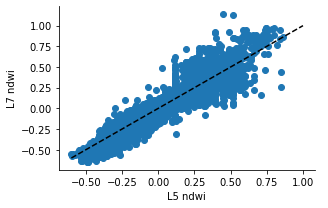

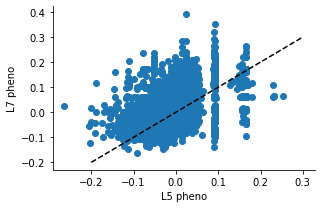

In [123]:
#0-327:5/7   328-584:7/8    585-638: 8/9
x5 = ee.Image(df1.loc[327, 'Image_x'])
x7 = ee.Image(df1.loc[327, 'Image_y'])
#Stop after 327

x5 = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(x5)))))
x7 = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(x7)))))
combined_image = x5.addBands(x7)
region = dissolve_ga #Will change based on cloud cover!
sample57 = combined_image.sampleRegions(collection = region, scale = 30)
sample57x = geemap.ee_to_pandas(sample57)

import seaborn as sns
g = sns.FacetGrid(data=sample57x, aspect=1.5, palette='BuGn')
g.map(plt.scatter, 'ndwi', 'ndwi_1').add_legend()
g.set_axis_labels("L5 ndwi", "L7 ndwi")
plt.plot([-0.6, 1], [-0.6, 1], 'k--')

g2 = sns.FacetGrid(data=sample57x, aspect=1.5, palette='BuGn')
g2.map(plt.scatter, 'pheno', 'pheno_1').add_legend()
g2.set_axis_labels("L5 pheno", "L7 pheno")
plt.plot([-0.2, 0.3], [-0.2, 0.3], 'k--')

In [245]:
df57 = df1.iloc[:328,:]

calibr = []
# calibr = pd.DataFrame()
for i in range(len(df57)):
    x = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df57.loc[i, 'Image_x']))))))
    y = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df57.loc[i, 'Image_y']))))))
    combined_image = x.addBands(y)
    try:
        region = dissolve_ga
        sample57x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
        calibr.append(sample57x) 

#     except Exception:
#         region = smalldissolve_ga
#         sample57 = combined_image.sampleRegions(collection = region, scale = 30)
#         sample57x = geemap.ee_to_pandas(sample57)
#         calibr = pd.concat([sample57x])

    except Exception:
        continue

calibr_list = pd.concat(calibr)

Shape_Leng    Shape_Area                    WETLAND_TY  ST_EMSD  \
0     1.602570e+06  2.045014e+08  Estuarine and Marine Wetland      109   
1     1.602570e+06  2.045014e+08  Estuarine and Marine Wetland        0   
2     1.602570e+06  2.045014e+08  Estuarine and Marine Wetland        0   
3     1.602570e+06  2.045014e+08  Estuarine and Marine Wetland        0   
4     1.602570e+06  2.045014e+08  Estuarine and Marine Wetland        0   
...            ...           ...                           ...      ...   
4232  1.602570e+06  2.045014e+08  Estuarine and Marine Wetland        0   
4233  1.602570e+06  2.045014e+08  Estuarine and Marine Wetland        0   
4234  1.602570e+06  2.045014e+08  Estuarine and Marine Wetland        0   
4235  1.602570e+06  2.045014e+08  Estuarine and Marine Wetland        0   
4236  1.602570e+06  2.045014e+08  Estuarine and Marine Wetland       76   

      ST_URAD  QA_PIXEL_1  ST_ATRAN_1  ST_EMIS_1  QA_RADSAT_1  ST_TRAD_1  ...  \
0        4731        5504        4380       9610            0       8892  ...   
1        4717        5440        4347       9880            0       9004  ...   
2        4717        5440        4347       9880            0       9004  ...   
3        4717        5440        4347       9880            0       9078  ...   
4        4717        5440        4347       9880            0       9078  ...   
...       ...         ...         ...        ...          ...        ...  ...   
4232     2392        5440        8248       9880            0       8334  ...   
4233     2392        5440        8248       9880            0       8297  ...   
4234     2392        5440        8247       9880            0       8223  ...   
4235     2392        5440        8248       9880            0       8223  ...   
4236     2392        5440        8246       9752            0       8148  ...   

      SR_CLOUD_QA_1   SR_B3_1  ST_DRAD_1  ST_CDIST     pheno     SR_B1  \
0                32  0.124115       1865        51  0.046893  0.046042   
1                 1  0.052395       1874        39  0.131015  0.041368   
2                 1  0.052395       1874        40  0.101101  0.041340   
3                 1  0.062213       1874        42  0.075146  0.049232   
4                 1  0.058940       1874        43  0.075366  0.049205   
...             ...       ...        ...       ...       ...       ...   
4232              1  0.054100        648       114 -0.066057  0.040130   
4233              1  0.054100        648       110 -0.079879  0.035208   
4234              1  0.039250        648       114  0.035670  0.031798   
4235              1  0.044255        648        98  0.042828  0.030065   
4236              1  0.039195        649       109 -0.019887  0.026600   

      ST_CDIST_1      ndwi  SR_ATMOS_OPACITY_1  ST_QA_1  
0             33  0.712627                  42      549  
1             66 -0.235540                  42      447  
2             69 -0.247972                  42      445  
3             75 -0.208972                  43      440  
4             78 -0.221760                  43      438  
...          ...       ...                 ...      ...  
4232         103 -0.132191                 156      337  
4233          98 -0.144808                 156      340  
4234         105 -0.351156                 156      336  
4235          85 -0.218783                 155      350  
4236          79 -0.282991                 158      357  

[250901 rows x 47 columns]

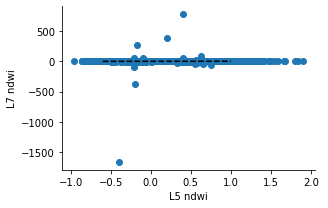

In [246]:
g = sns.FacetGridrid(data=calibr_list, aspect=1.5, palette='BuGn')
g.map(plt.scatter, 'ndwi', 'ndwi_1').add_legend()
g.set_axis_labels("L5 ndwi", "L7 ndwi")
plt.plot([-0.6, 1], [-0.6, 1], 'k--')

display(calibr_list)

In [247]:
# print(ee.String(x5.get('system:id')))

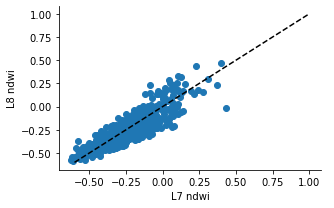

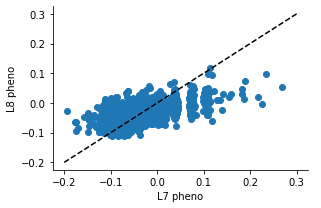

In [117]:
#0-327:5/7   328-584:7/8    585-638: 8/9
x7 = ee.Image(df1.loc[450, 'Image_x'])
x8 = ee.Image(df1.loc[450, 'Image_y'])
#Stop after 584

x7 = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(x7)))))
x8 = ee.Image(addFLATS(addpheno(addndwi(maskL5sr(x8)))))
combined_image = x7.addBands(x8)
region = smalldissolve_ga #Will change based on cloud cover!
sample78 = combined_image.sampleRegions(collection = region, scale = 30)
sample78x = geemap.ee_to_pandas(sample78)

import seaborn as sns
g = sns.FacetGrid(data=sample78x, aspect=1.5, palette='BuGn')
g.map(plt.scatter, 'ndwi', 'ndwi_1').add_legend()
g.set_axis_labels("L7 ndwi", "L8 ndwi")
plt.plot([-0.6, 1], [-0.6, 1], 'k--')

g2 = sns.FacetGrid(data=sample78x, aspect=1.5, palette='BuGn')
g2.map(plt.scatter, 'pheno', 'pheno_1').add_legend()
g2.set_axis_labels("L7 pheno", "L8 pheno")
plt.plot([-0.2, 0.3], [-0.2, 0.3], 'k--')

In [87]:
print(ee.String(x8.get('system:id')))

ee.String({
  "functionInvocationValue": {
    "functionName": "Element.get",
    "arguments": {
      "object": {
        "functionInvocationValue": {
          "functionName": "Image.addBands",
          "arguments": {
            "dstImg": {
              "functionInvocationValue": {
                "functionName": "Image.addBands",
                "arguments": {
                  "dstImg": {
                    "functionInvocationValue": {
                      "functionName": "Image.addBands",
                      "arguments": {
                        "dstImg": {
                          "functionInvocationValue": {
                            "functionName": "Image.updateMask",
                            "arguments": {
                              "image": {
                                "functionInvocationValue": {
                                  "functionName": "Image.updateMask",
                                  "arguments": {
                                    "ima

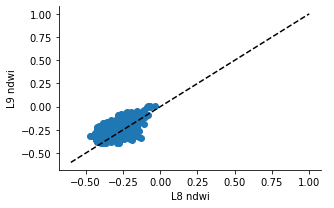

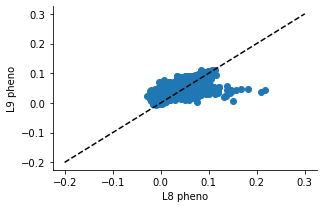

In [110]:
#0-327:5/7   328-584:7/8    585-638: 8/9
x8 = ee.Image(df1.loc[623, 'Image_x'])
x9 = ee.Image(df1.loc[623, 'Image_y'])

x8 = ee.Image(addFLATS(addpheno(addndwi(maskL5sr(x8)))))
x9 = ee.Image(addFLATS(addpheno(addndwi(maskL5sr(x9)))))
combined_image = x8.addBands(x9)
region = dissolve_ga #Will change based on cloud cover!
sample89 = combined_image.sampleRegions(collection = region, scale = 30)
sample89x = geemap.ee_to_pandas(sample89)

import seaborn as sns
g = sns.FacetGrid(data=sample89x, aspect=1.5, palette='BuGn')
g.map(plt.scatter, 'ndwi', 'ndwi_1').add_legend()
g.set_axis_labels("L8 ndwi", "L9 ndwi")
plt.plot([-0.6, 1], [-0.6, 1], 'k--')

g2 = sns.FacetGrid(data=sample89x, aspect=1.5, palette='BuGn')
g2.map(plt.scatter, 'pheno', 'pheno_1').add_legend()
g2.set_axis_labels("L8 pheno", "L9 pheno")
plt.plot([-0.2, 0.3], [-0.2, 0.3], 'k--')

In [99]:
print(ee.String(x9.get('system:id')))

ee.String({
  "functionInvocationValue": {
    "functionName": "Element.get",
    "arguments": {
      "object": {
        "functionInvocationValue": {
          "functionName": "Image.addBands",
          "arguments": {
            "dstImg": {
              "functionInvocationValue": {
                "functionName": "Image.addBands",
                "arguments": {
                  "dstImg": {
                    "functionInvocationValue": {
                      "functionName": "Image.addBands",
                      "arguments": {
                        "dstImg": {
                          "functionInvocationValue": {
                            "functionName": "Image.updateMask",
                            "arguments": {
                              "image": {
                                "functionInvocationValue": {
                                  "functionName": "Image.updateMask",
                                  "arguments": {
                                    "ima